# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically. 
* Failure to comply with the following instructions will result in a significant penalty. 
* Appeals regarding your failure to read these instructions will be denied. 
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions: 

316492776
318900016

---
---


In [1]:
# Required dependencies
!pip3 install numpy scipy pandas scikit-learn matplotlib mpl-tools tqdm seaborn

In [2]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from scipy.spatial.distance import cdist, pdist, squareform
from sklearn.manifold import TSNE
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    precision_score,
    recall_score,
    silhouette_score,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.auto import tqdm

sns.set_theme()
np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

tSNE is a non-linear dimensionality reduction algorithm, used mostly for the purpose of visualization in 2d and sometimes 3d.
Its input is $n$ points in a high dimentional space $\mathbb{R}^h$, and its output is $n$ correspoinding points in a $\mathbb{R}^2$ (or $\mathbb{R}^3$).

The algorithm calculates pairwise distances is the original space, tranlates them to a "similarity" probabilty distribution $p_{ij}$ using gaussians, and tries to make the similarities in the lower dimensional space $q_{ij}$ have that same distribution (this time with T-distribution - more about that below).

Its cost function is KL-divergence between P and Q, which represents "distance" between distribution. It is minimized using gradient decsent.

KL-devergence defenition, $\sum_{i,j=1}^{N}{p_{ij} \cdot \log{\frac{p_{ij}}{q_{ij}}}}$, causes higher $p_{ij}$ values to be more important than smaller ones, meaning tSNE generally focuses on preserving local structure (=higher $p_{ij}$ values corresponding to closer points in the original space) but sometimes fail to capture global relationships.

This property, however convinient for visualization, means that tSNE is generally not a good choice to be used as a more "mathematical" option for dimensionality reduction, since it does not preserve basic geometric features of the data in the original space.

Unlike regular SNE, tSNE is symetric, and uses T-distribution in the lower dimentional space in order to avoid shrinkage to a single point or a very dense cluster (since T-distribution has a heavy tail, unlike a gaussian which does not).

The (important) hyperparameters:
- n_components: the low dimension (almost always 2 or 3)
- perplexity: relates to the amount of neighbors to be considered when calculating $\sigma_i$
- n_iter: the maximal number of iterations of the gradient descent process.
- learning rate: learning rate for the gradient descent algorithm. High learning rate leads to faster loss decrease but may also fail to converge at later iterations. Low learning rates suffer less from that, but convergence more slowly and require more steps (and time) to reach small loss values. SKLearn implements "auto" method, which changes lr over time.
- method: SKLearn supports the 'barnes_hut' distance approximations, which causes $q_{ij}$ to be $O(n \log{n})$ rather than $O(n^2)$. It is less precise, but makes the algorithm way more scalable. Exact calculations become impractical with thousands of examples since $O(n^2)$ increases fast, while $O(n \log{n})$ still performs well.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

We implement t-SNE as seen in the class, more specifically according to slides 61-66.
The calculation of $q_{ij}$ and $p_{ij}$ is pretty straight forward according to the theorey shown in class.

We implemented a search to find $\sigma_i$ for each example, as suggested in the piazza forum. For each example, we choose $\sigma_i$ that achieves the desired perplexity. We implemented this by using a vectorized binary search (for all $\sigma_i$ together), increasing or descreasing sigma to get closer to the desired perplexity. Since we cut the search space by half each iteration, the process converges fast.
The (configurable) default sigma values are between $10^{-3}$ and $10^3$ with precision of $10^{-4}$, which covers more than enough values (when we ran the algorithm, final sigma values were all between $10^{-1}$ and $10^1$)

We did not implement 'barnes_hut' optimization and we stick to the exact method since, meaning we don't scale so well for large numbers of examples. We did, however, make sure to write vectorized code to maximize efficiency and speed as much as possible, so we handle thousands of examples with little effort. 

We also did not implement lr decay methods, since using relatively low values and increasing the max steps seemed to do the job (graphs later), and did not take too much time to run.

The optimization is done by gradient descent process, with an option for early stopping if no progress is made after some time.

We added few more parameters to the original signature:
- n_iter_without_progress: number of iterations to wait before early stopping if the loss hasn't decreased.
- verbose: verbosity, used to help us debug (helpful prints and progress bars)
- min_sigma & max_sigma: control the range of values that $\sigma_i$ can get
- transform_n_neighbors: the number of neighbors from the train to be considered when calculating the transform method.

In [3]:
class CustomTSNE:
    def __init__(
        self,
        perplexity: float = 30.0,
        n_components: int = 2,
        n_iter: int = 1000,
        learning_rate: float = 200.0,
        n_iter_without_progress: int = 300,
        verbose: bool = False,
        min_sigma: float = 1e-3,
        max_sigma: float = 1e3,
        transform_n_neighbors: int = 10,
    ):
        self.perplexity = perplexity
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        # Note: You may add more attributes
        self.n_iter_without_progress = n_iter_without_progress
        self.verbose = verbose
        self.min_sigma = min_sigma
        self.max_sigma = max_sigma
        self.transform_n_neighbors = transform_n_neighbors

    def fit_transform(self, X):
        # Part 1: Implementing t-SNE

        # Step 1: Compute pairwise affinities in the original space with a Gaussian distribution
        # Your code here
        X = X / np.max(X)
        N = len(X)
        X_dists = squareform(pdist(X))
        p_ij = self.calc_pij(X_dists)
        p_ij = p_ij[~np.eye(N, dtype=bool)].reshape(N, -1)

        Y = np.random.random((N, self.n_components))

        best_i, best_C = -1, np.inf
        self.C_history = []
        for i in tqdm(range(self.n_iter), disable=not self.verbose, desc="iteration"):
            Y_diff = Y[:, np.newaxis, :] - Y
            # remove i=j cases
            Y_diff = Y_diff[~np.eye(N, dtype=bool)].reshape(N, N - 1, -1)
            Y_dists = np.linalg.norm(Y_diff, axis=-1)
            Y_dists = 1 + Y_dists**2
            Y_dists = Y_dists**-1
            # normalize to a probabilty
            q_ij = Y_dists / np.sum(Y_dists)

            C = p_ij * np.log(p_ij / q_ij)
            C = float(np.sum(C))
            self.C_history.append(C)
            if self.verbose:
                print(f"After {i} iterations, {C=}")
            if C < best_C:
                best_i, best_C = i, C
            if best_i + self.n_iter_without_progress < i:
                if self.verbose:
                    print(
                        f"C has not improved for {self.n_iter_without_progress} steps. Stopping early."
                    )
                return Y
            # grad step
            grad_C_yi = 4 * np.sum(
                (p_ij - q_ij)[..., np.newaxis] * Y_diff * Y_dists[..., np.newaxis],
                axis=1,
            )
            Y -= self.learning_rate * grad_C_yi
        if self.verbose:
            print(f"{C=} after {self.n_iter} iterations")
        # Return Y, the 2D representation of the input data
        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        N = len(X_original)
        n_neighbors = min(N, int(self.transform_n_neighbors))
        Y_new = []

        # Added weights to the distances as following: [1, 1/2, 1/3, 1/4.... 1/n]
        # The minimal distance get's the highest weight, and the weight is reduced as the distance increasing
        W_arr = np.arange(1, n_neighbors + 1, dtype=float) ** -1

        # Calculate the distance array for each one of the test values
        dists = cdist(X_new, X_original)

        # Sort the indices of the distances from minimal to maximal while limit just to the n_neighbors distances
        n_nearest_indexes = np.argsort(dists, axis=1)[:, :n_neighbors]

        # Find the average location based on the indices of the distances, while the distances are weighted (Minimal distance -> max weight)
        Y_new = np.average(Y_original[n_nearest_indexes], weights=W_arr, axis=1)

        return np.array(Y_new)

    def calc_pij(self, X_dists):
        N = len(X_dists)
        min_sigma = np.ones((N, 1)) * self.min_sigma
        max_sigma = np.ones((N, 1)) * self.max_sigma
        # precision is min_sigma / 10
        n_iters = int(np.ceil(np.log2(self.max_sigma / (self.min_sigma / 10))))
        for _ in tqdm(range(n_iters), disable=not self.verbose, desc="finding sigma"):
            curr_sigma = (min_sigma + max_sigma) / 2
            p_ij = -(X_dists**2) / (2 * curr_sigma**2)
            # remove i=j cases
            p_ij = p_ij[~np.eye(N, dtype=bool)].reshape(N, -1)
            # numeric stability in exponent
            p_ij -= p_ij.max(axis=1, keepdims=True)
            p_ij = np.exp(p_ij)
            # normalize to a probabilty
            p_ij = p_ij / p_ij.sum(axis=1, keepdims=True)
            distribution_entropy = (-p_ij * np.log2(p_ij)).sum(axis=1, keepdims=True)
            distribution_perplexity = 2**distribution_entropy
            # update sigma
            min_sigma, max_sigma = (
                np.where(
                    distribution_perplexity < self.perplexity, curr_sigma, min_sigma
                ),
                np.where(
                    distribution_perplexity > self.perplexity, curr_sigma, max_sigma
                ),
            )
        # reconstruct diagonal
        p_ij = np.insert(p_ij, np.arange(0, N**2, N), 0).reshape((N, N))
        return (p_ij + p_ij.T) / (2 * N)

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

We chose to use MNIST dataset to our algorithm.
MNIST is a very popular yet simple dataset, which is used wordlwide for basic/begginer ML tasks, and has many examples specifically for dimensionality reduction outputs (PCA and tSNE). This will allow us to compare ourself. 
It's usage is about encoding a digit in an image (Assuming the digit is shown as pixels just like one takes a photo of a car plate), and each image is labeled by it's digit value

Using T-SNE algorithm, we can find the relationship and the distances between the images with a very clear and visual way, while since we have just 10 digits in MNIST (0-9), we can classify the images into 10 groups and show in 2D dimension the relationship and distance between them

We split the dataset into train (80%) and test (20%) while the dataset contains 10,000 examples in total

Since the image values are described by grayscale pixel codes (0 -> white to 255 -> black), the digits should be represented as black while the background as white, but in fact the digits are in various range of colors between white and black (gray, dark gray. etc). Then, in order to reduce errors since the colors distribution, we want to normalize it so the digit will be represented with one single pixel code.

In [4]:
# Loading the data into train / test datasets
N_samples = 1000
dataset = pd.read_csv("./Dataset/mnist_dataset.csv")[:N_samples]

# The X axis is the pixels grayscale matrix that represents the digit
X = dataset.loc[:, "1x1":].values

# The y axis is the actual digit that the the pixels matrix represents
y = dataset.loc[:, "label"].values

X_train, X_test, label_train, label_test = train_test_split(X, y, test_size=0.2)

# Normalizing the grayscale codes by minmax scaler.
sc = MinMaxScaler()
X_train_normalized_opt1 = sc.fit_transform(X_train)
X_test_normalized_opt1 = sc.transform(X_test)

# Normalizing the grayscale codes by standard scaler
sc = StandardScaler()
X_train_normalized_opt2 = sc.fit_transform(X_train)
X_test_normalized_opt2 = sc.transform(X_test)

In [5]:
dataset.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
X_train.shape

(800, 784)

In [7]:
X_train_normalized_opt1.shape

(800, 784)

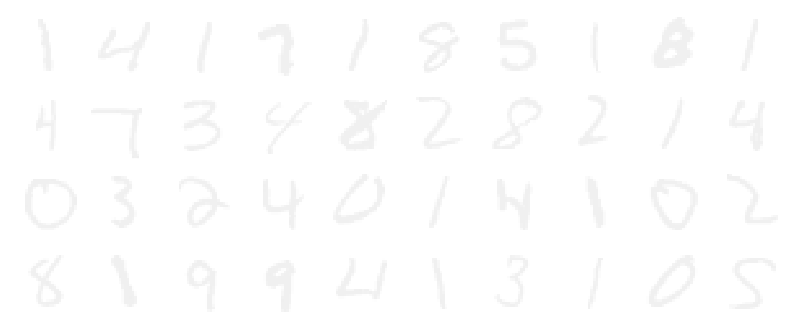

In [8]:
# This is a ploting of sample train data

fig, axes = plt.subplots(
    4,
    10,
    figsize=(10, 4),
    subplot_kw={"xticks": [], "yticks": []},
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
)
for i, ax in enumerate(axes.flat):
    ax.imshow(
        X_train_normalized_opt1[i].reshape(28, 28),
        cmap="binary",
        interpolation="nearest",
        clim=(0, 16),
    )

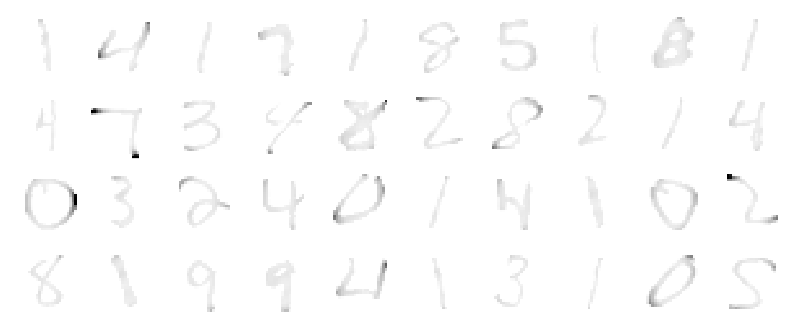

In [9]:
# This is a ploting of sample train data

fig, axes = plt.subplots(
    4,
    10,
    figsize=(10, 4),
    subplot_kw={"xticks": [], "yticks": []},
    gridspec_kw=dict(hspace=0.1, wspace=0.1),
)
for i, ax in enumerate(axes.flat):
    ax.imshow(
        X_train_normalized_opt2[i].reshape(28, 28),
        cmap="binary",
        interpolation="nearest",
        clim=(0, 16),
    )

# t-SNE demonstration 
Demonstrate your t-SNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

As we can see below, we've tested the module with a various combination of Hypher-Parameters. We ran everything on $N=1000$ MNIST examples, enough to see trends and still run fast at $O(N^2)$ time.

The most important hypher-param is the perplexity. We found that a large number of perplexity causes a very dense and unified groups of digits but with some little mistakes since with high perplexity we can also "catch" neighbors that represents another disits. However, with a low number of perplexity the observabilities will not be unified and scattered along the graph
Therefore, according to our research the optimal perplexity number is something about 30-50.

Regarding learning rate, higher learning rate causes the group be closer to each other, and smaller learning rate makes the groups be more far away, since the Y output values are getting more centralized with higher learning rate value. The optimal learning rate is about 100-200. However, it has less affect on the results than the perplexity, and affects mostly the runtime.

Redarding the number of iterations, we've tested with 1000 and 500 iterations and didn't find meaningful changes. This is also expressed in the loss over time graphs, which show that the loss decreases fast early on then slower as it reaches smaller values.
It is important to note that a large number of iterations can cause overfitting (if we didn't implement early stopping), and smaller one can cause underfitting.

Therefore, according to our experiments, we've found that the best hyper-parameters combination is as follows:
* Perplexity of 50 (As previously told, small enough to not catch neigbors from another digits and large enough to make a unified and clear groups)
* Learning rate of 200 (In order to make the groups unified and clear)
* 1000 iterations

In [10]:
hypher_pharams_options = [
    {"n_components": 2, "n_iter": 1000, "perplexity": 100, "learning_rate": 200},
    {"n_components": 2, "n_iter": 1000, "perplexity": 50, "learning_rate": 200},
    {"n_components": 2, "n_iter": 1000, "perplexity": 30, "learning_rate": 100},
    {"n_components": 2, "n_iter": 500, "perplexity": 30, "learning_rate": 100},
    {"n_components": 2, "n_iter": 1000, "perplexity": 15, "learning_rate": 50},
    {"n_components": 2, "n_iter": 1000, "perplexity": 50, "learning_rate": 200},
    {"n_components": 2, "n_iter": 1000, "perplexity": 5, "learning_rate": 50},
]

best_hypher_pharams_options = [
    {"n_components": 2, "n_iter": 1000, "perplexity": 50, "learning_rate": 200}
]

results_array = []

for hypher_params in hypher_pharams_options:
    n_components = hypher_params["n_components"]
    n_iter = hypher_params["n_iter"]
    perplexity = hypher_params["perplexity"]
    learning_rate = hypher_params["learning_rate"]
    print(
        f"Running with number of components {n_components}, number of iterations {n_iter}, perplexity {perplexity} and lr {learning_rate}"
    )

    # Run your custom t-SNE implementation
    custom_tsne = CustomTSNE(
        n_components=n_components,
        n_iter=n_iter,
        perplexity=perplexity,
        learning_rate=learning_rate,
    )
    custom_Y = custom_tsne.fit_transform(X_train_normalized_opt1)

    # Run sklearn t-SNE
    sk_tsne = TSNE(n_components=n_components, init="random", perplexity=perplexity)
    sk_Y = sk_tsne.fit_transform(X_train_normalized_opt1)
    custom_silhouette = silhouette_score(custom_Y, label_train)
    sk_silhouette = silhouette_score(sk_Y, label_train)

    results_array.append(
        {
            "custom_Y": custom_Y,
            "sk_Y": sk_Y,
            "custom_kl": custom_tsne.C_history,
            "sk_kl": sk_tsne.kl_divergence_,
            "custom_silhouette": custom_silhouette,
            "sk_silhouette": sk_silhouette,
        }
    )

Running with number of components 2, number of iterations 1000, perplexity 100 and lr 200
Running with number of components 2, number of iterations 1000, perplexity 50 and lr 200
Running with number of components 2, number of iterations 1000, perplexity 30 and lr 100


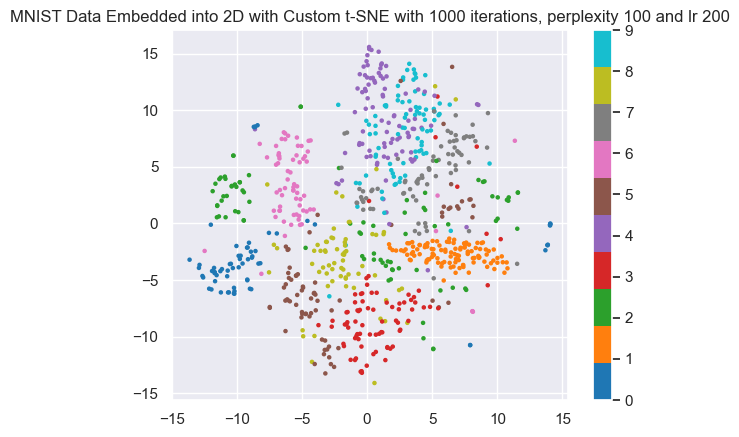

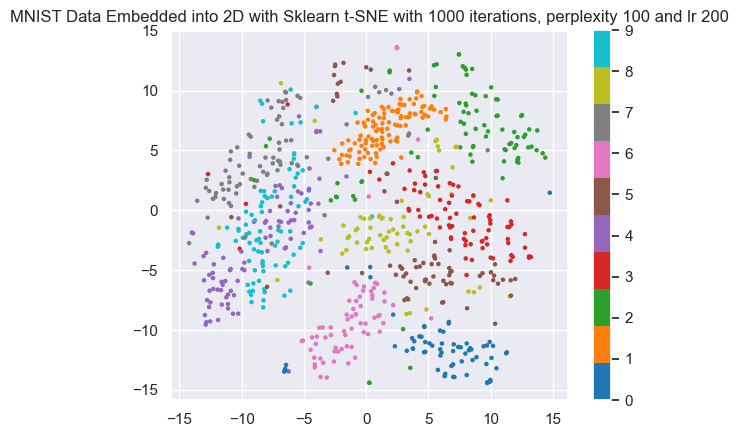

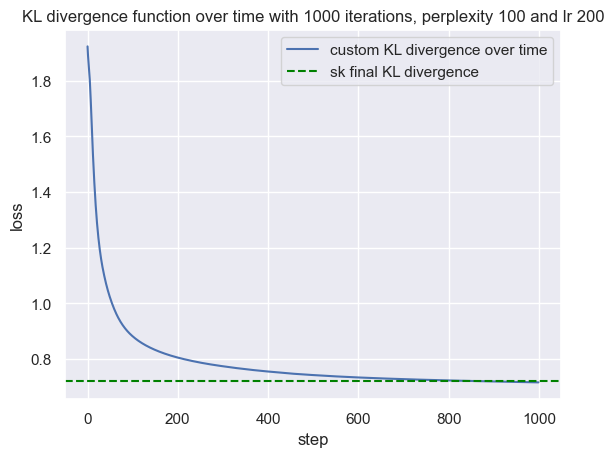

Custom silhouette: 0.104
SK silhouette: 0.152


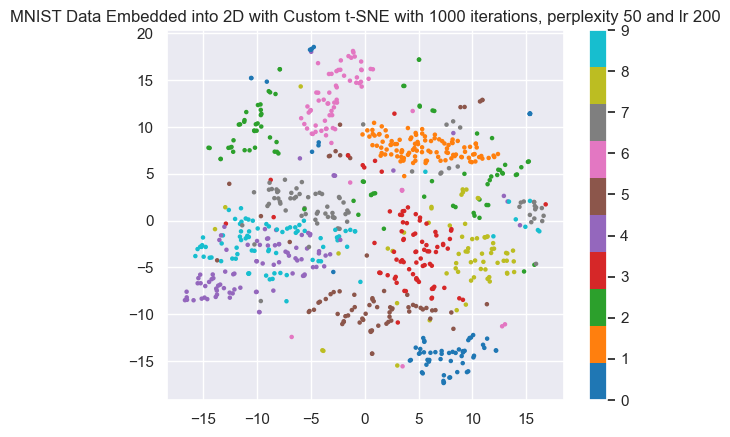

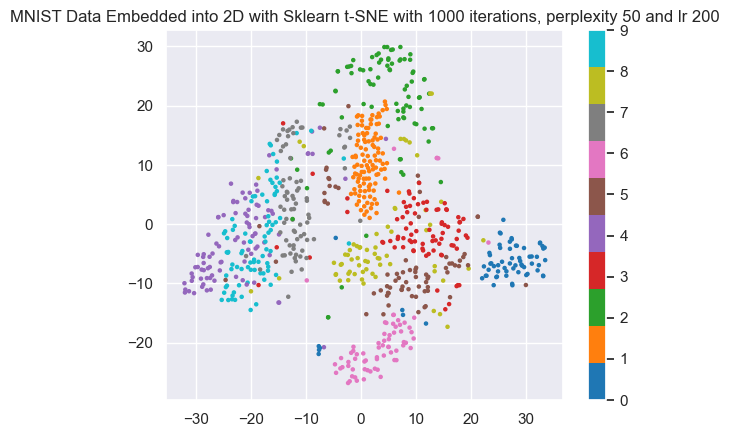

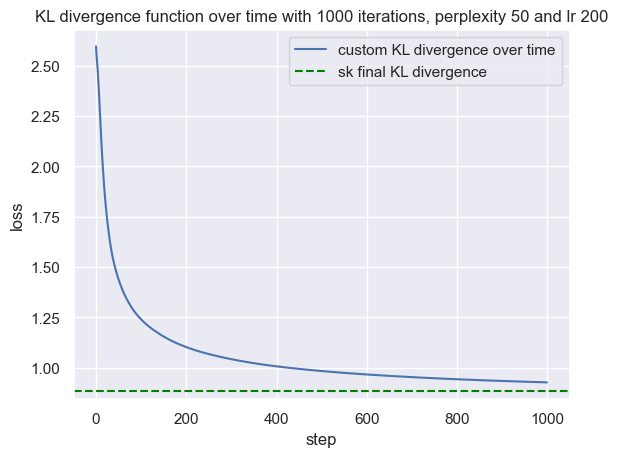

Custom silhouette: 0.104
SK silhouette: 0.152


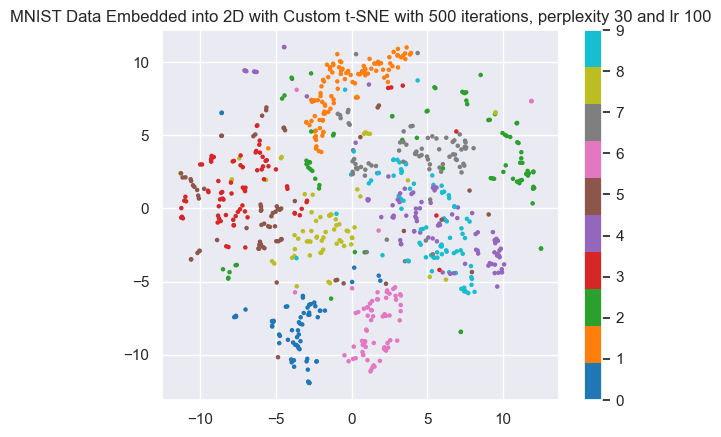

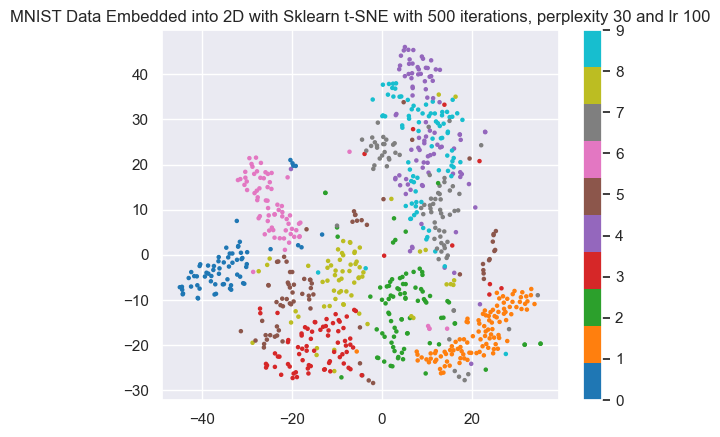

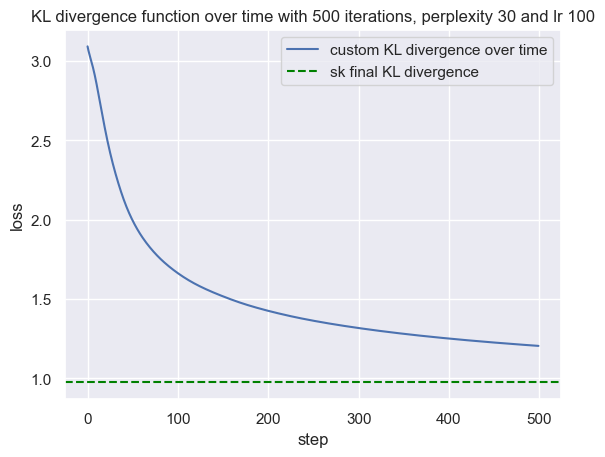

Custom silhouette: 0.104
SK silhouette: 0.152


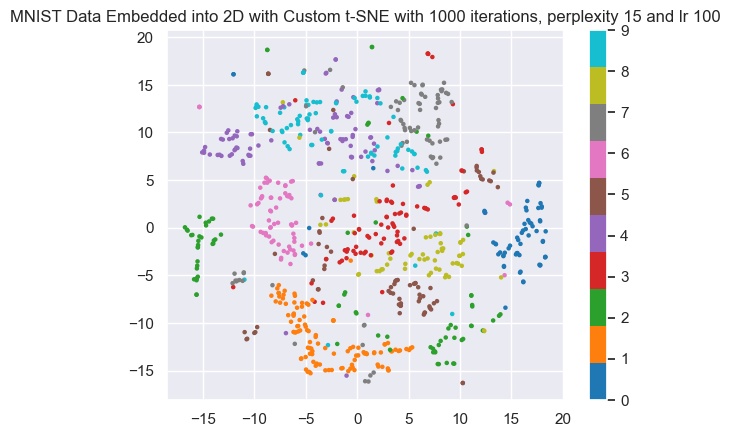

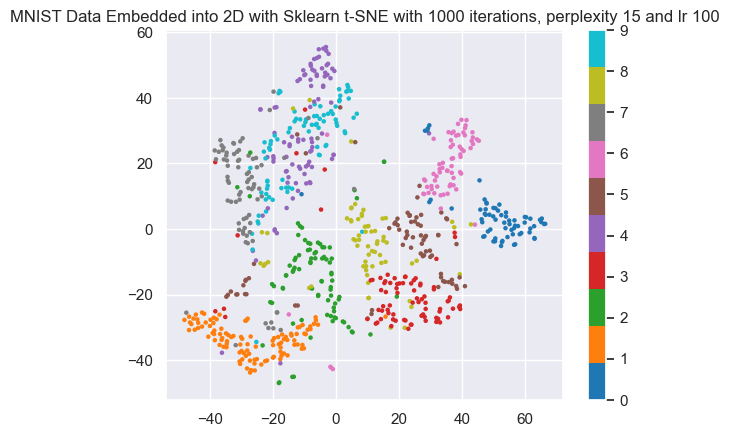

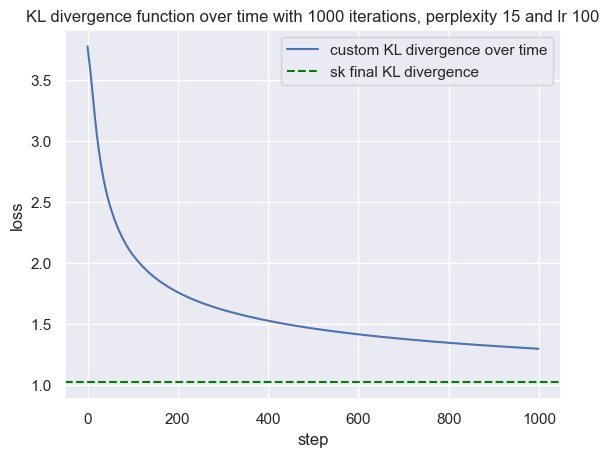

Custom silhouette: 0.104
SK silhouette: 0.152


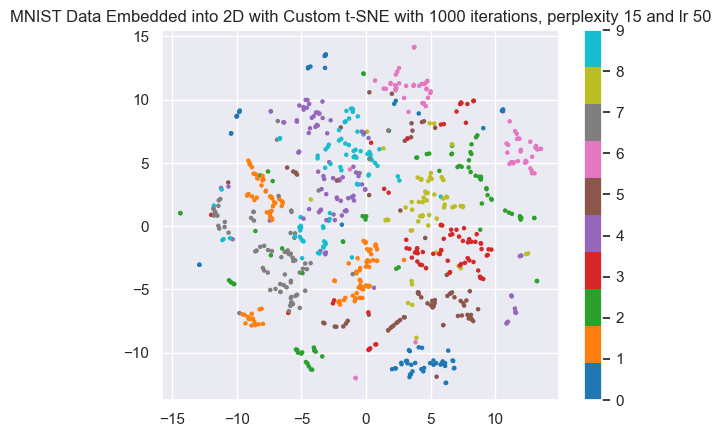

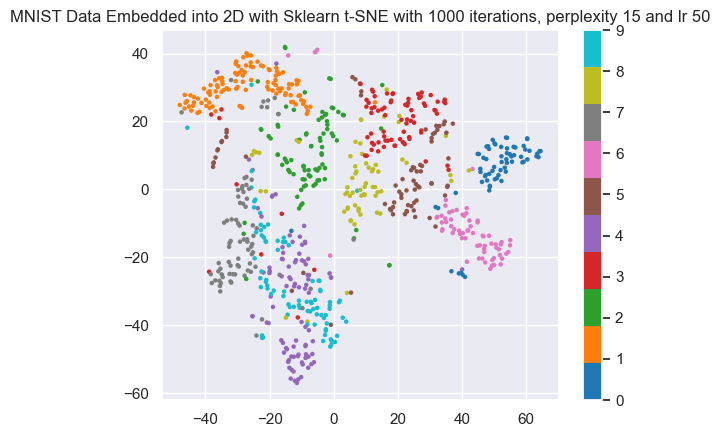

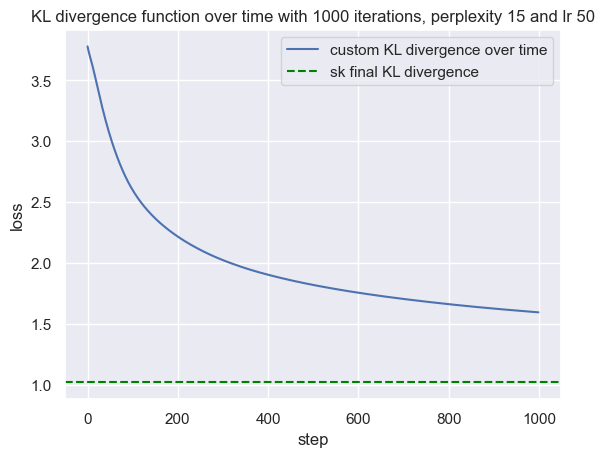

Custom silhouette: 0.104
SK silhouette: 0.152


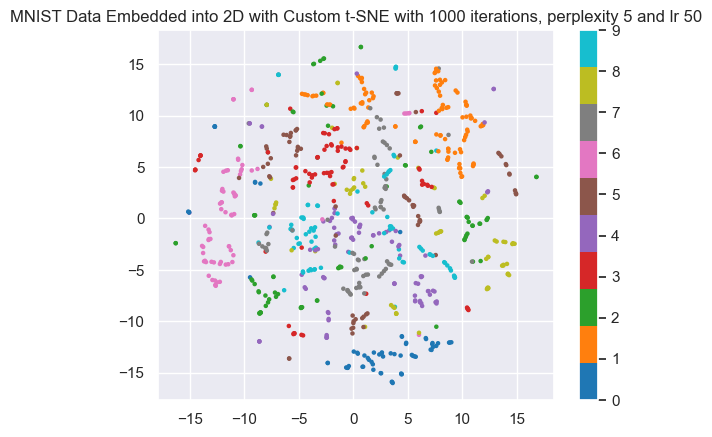

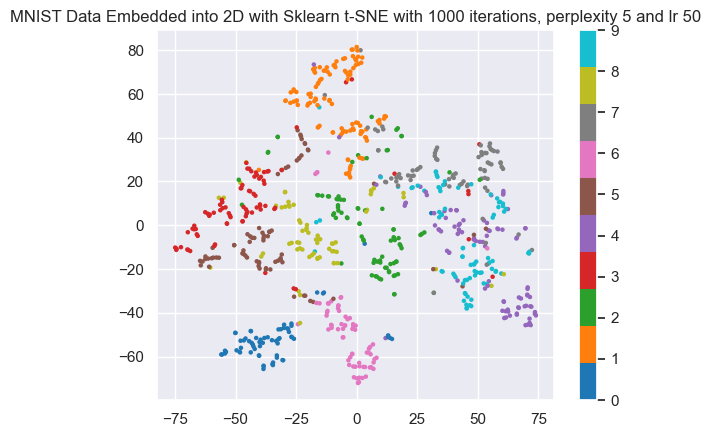

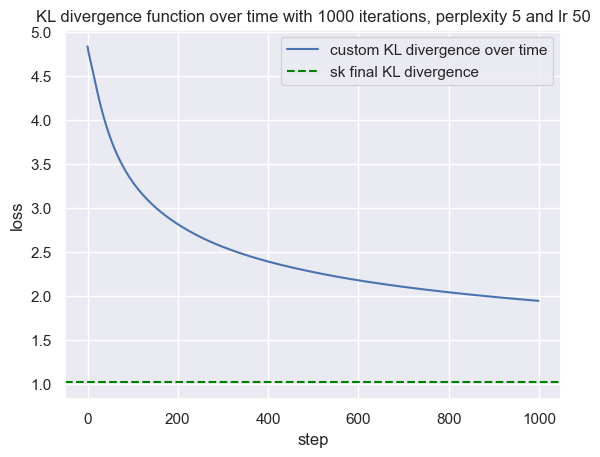

Custom silhouette: 0.104
SK silhouette: 0.152


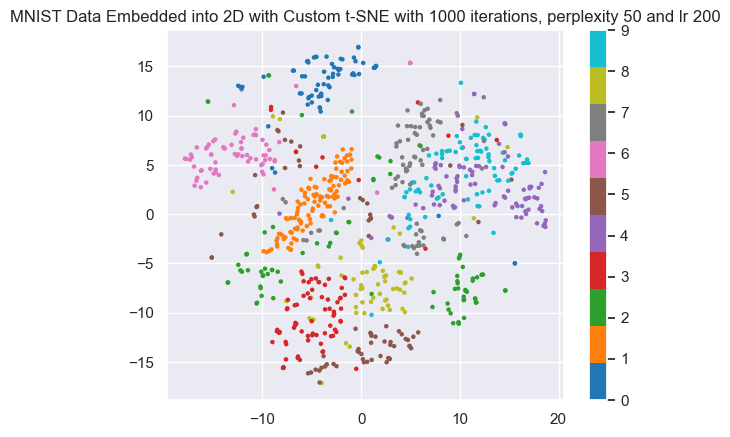

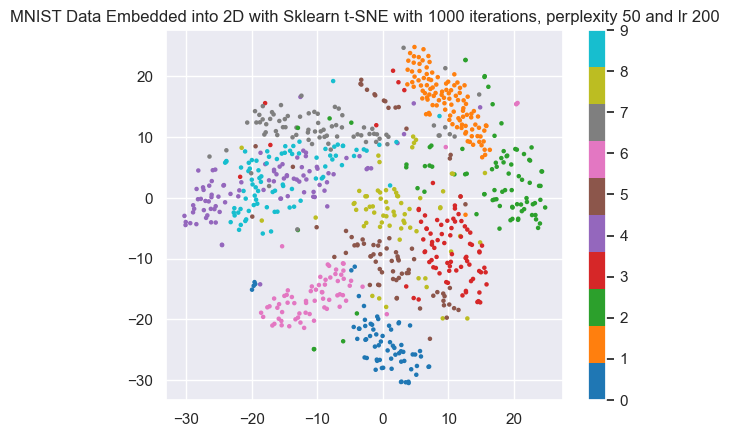

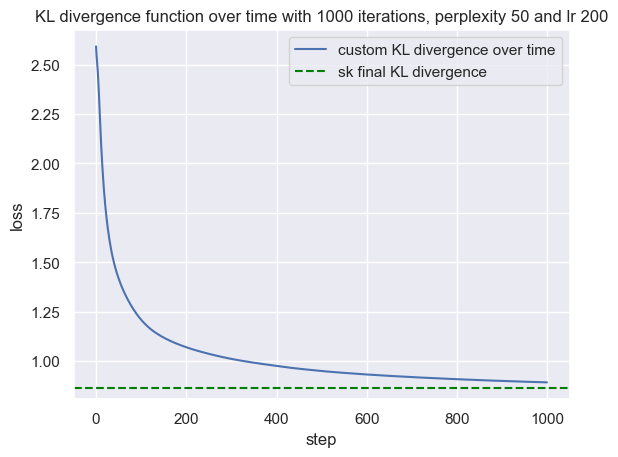

Custom silhouette: 0.104
SK silhouette: 0.152


In [ ]:
for idx, result in enumerate(results_array):
    hyperparams_string = f"{hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}"
    # Visualization of the result
    plt.figure()
    plt.scatter(
        result["custom_Y"][:, 0],
        result["custom_Y"][:, 1],
        s=5,
        c=label_train.astype(int),
        cmap="tab10",
    )
    plt.colorbar()
    plt.title(
        f"MNIST Data Embedded into 2D with Custom t-SNE with {hyperparams_string}"
    )
    plt.show()

    plt.figure()
    plt.scatter(
        result["sk_Y"][:, 0],
        result["sk_Y"][:, 1],
        s=5,
        c=label_train.astype(int),
        cmap="tab10",
    )
    plt.colorbar()
    plt.title(
        f"MNIST Data Embedded into 2D with Sklearn t-SNE with {hyperparams_string}"
    )
    plt.show()

    plt.figure()
    plt.plot(
        np.arange(len(result["custom_kl"])),
        result["custom_kl"],
        label="custom KL divergence over time",
    )
    plt.axhline(
        y=result["sk_kl"], label="sk final KL divergence", color="green", linestyle="--"
    )
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend()
    plt.title(f"KL divergence function over time with {hyperparams_string}")
    plt.show()

    print(f"Custom silhouette: {custom_silhouette:.3f}")
    print(f"SK silhouette: {sk_silhouette:.3f}")

In terms of visual results, both outputs look good - we have clear seperation of different digits.
The quality of the embeddings is also good - the loss decreases along the learning process, and the final KL divergence is always close between the implementations - it depends on the hyperparams of course, but we did not see any major preference twords one implementation over the that note subject.

As noted before, the most important difference between our and sk-learn's implementation is the running time. Ours runs in $O(N^2)$ while sk's runs in $O(N \log{N})$ which is way better especially as $N$ grows larger.

# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

We chose to use the transform method as following:
1. For each one of the test set observabilities, we've calculated the distance from it's grayscale vector to any of the grayscale vectors in the train set
2. We find the top n nearest vectors (While n is the perplexity used in the fit_transofrm method) and we build a new matrix of (n X 2) that contains the original Y values of the n nearest vectors from the train set, sorted from 1st nearest to n nearest (Each Y value contains 2 values, the x axis and the y axis in the target 2D graph)
3. The target Y value of the test grayscale vector is the weighted average of the Y values of the n nearest vectors from the train set. While the weight of each value is $\frac{1}{i}, 1 \leq i \leq n$ (The nearest value is weighted by $1$, the 2nd by $\frac{1}{2}$, the 3rd by $\frac{1}{3}$, and the n by $\frac{1}{n}$)
4. We repeat this for each one of the test values, until we build a final Y vector of shape $(N_{test}, 2)$ representing 2D values to be in the graph.

The reason we compare the distances between the grayscale vectors of each one of the test examples to the train examples, is the assumption that each digit represented by a pixel code is not exactly the same as other pixel code vectors of the same digit, but the distance is minimal to grayscale vectors represents the same digit.
Then we assume that most of the n grayscale nearest vectors represents the same digit as the test sample.

Then we want to locate it around the n grayscale nearest vectors but with more weight to the closest vector and less weight as the vector is getting less close.

With that approach we set the Y vectors of the test samples around the group of their digits.

In order to measure the performance of each one of the examples, I've added two dataframe tables for each one of the experiments:
1. The first table compares each test observability actual digit with it's 10 closets train actual digits (As more neighbors have the same digit as the test observability, then the experiment is better)
2. The second tables measures the 10 closest train distances to each one of the test observabilities 

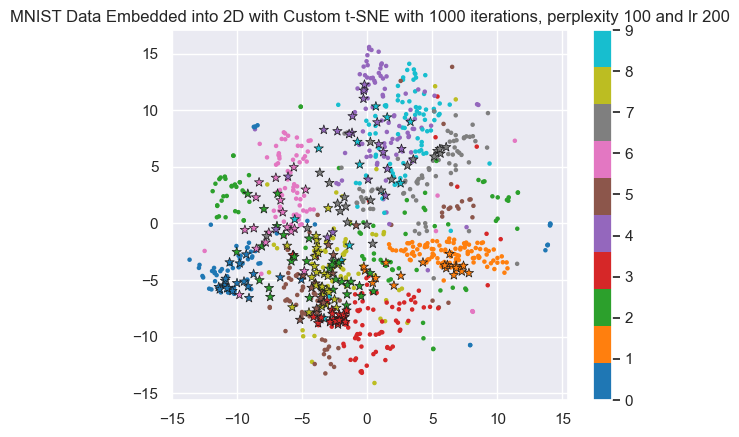

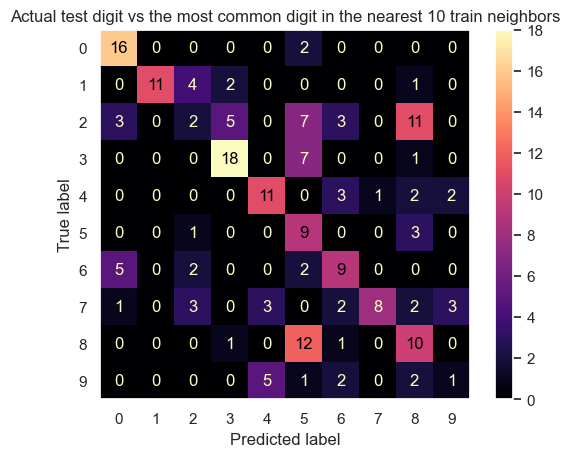

,precision,recall
0,0.518003,0.475


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,9,7,9,7,9,9,9,9,7,7
1,6,2,2,0,0,0,0,2,2,2,0
2,4,4,4,4,4,7,4,4,9,4,4
3,4,6,6,7,7,6,6,6,6,9,4
4,7,2,2,2,2,8,8,2,8,7,8
5,9,4,4,4,4,7,9,4,7,4,4
6,7,8,8,7,7,4,7,9,7,7,4
7,2,8,8,8,8,8,8,8,8,8,8
8,7,7,7,7,9,2,7,7,9,3,7
9,0,0,0,0,0,0,0,0,0,6,0


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.144449,0.343438,0.374608,0.422155,0.452609,0.472500,0.759158,0.781413,0.890482,0.903401
1,6,0.829152,0.850709,1.179492,1.566422,1.566758,1.579234,1.644873,1.807624,1.853125,1.861707
2,4,0.233664,0.649556,0.802221,0.892609,0.918490,0.964821,1.009435,1.100028,1.113352,1.156769
3,4,1.381593,1.522130,1.622596,1.797317,2.178836,2.229346,2.278104,2.439738,2.469826,2.617020
4,7,0.336822,0.497338,0.891915,0.922838,0.931533,1.142013,1.291130,1.350171,1.352949,1.406592
5,9,0.197748,0.301402,0.409476,1.006656,1.140232,1.164514,1.211974,1.233379,1.372662,1.510168
6,7,0.187201,0.760907,1.046084,1.094672,1.252983,1.274887,1.288435,1.362746,1.363439,1.393086
7,2,0.181525,0.490767,0.698262,0.749644,0.864377,0.951207,0.962254,1.014786,1.032070,1.060227
8,7,0.500896,0.576133,0.795347,0.865982,0.879875,0.884990,0.917131,1.088107,1.218889,1.229703
9,0,0.254429,0.354037,0.533544,0.597263,1.092457,1.134946,1.249749,1.261397,1.498699,1.574270


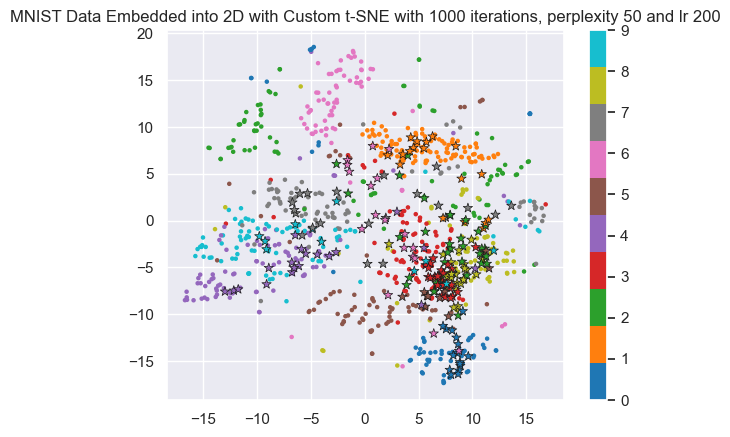

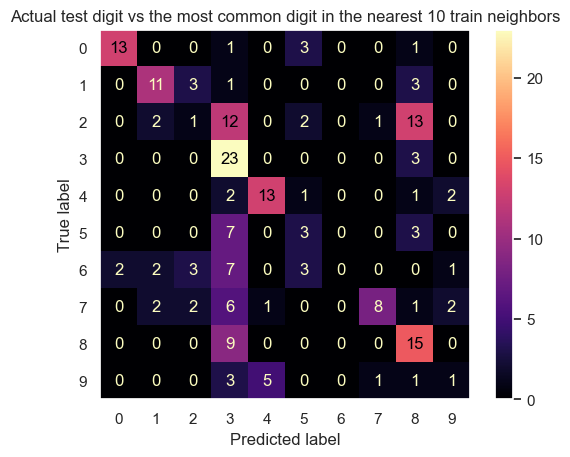

c:\Users\Roey\anaconda3\envs\advanced_ml\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall
0,0.417889,0.44


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,9,9,4,4,4,7,4,9,9,4
1,6,3,3,3,3,3,3,3,3,3,3
2,4,9,9,4,9,5,9,9,9,9,4
3,4,4,4,7,9,4,4,4,4,4,9
4,7,8,8,2,2,2,8,3,3,3,3
5,9,9,9,9,9,9,9,9,7,9,4
6,7,9,4,7,7,7,4,9,9,7,7
7,2,3,3,8,3,3,3,3,3,8,8
8,7,7,2,7,7,7,9,9,9,7,9
9,0,5,0,0,0,0,0,0,0,0,0


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.385862,0.577862,1.038255,1.268396,1.269839,1.292475,1.326041,1.502137,1.511899,1.525038
1,6,0.562757,0.627247,0.696022,0.751954,1.030082,1.064825,1.250083,1.288262,1.349890,1.377516
2,4,0.257709,0.490189,0.606054,0.836902,0.888046,0.966807,0.995688,1.029420,1.154247,1.229049
3,4,0.568663,0.714179,0.778043,0.923057,1.065867,1.071827,1.082019,1.224736,1.266811,1.433763
4,7,0.666498,0.711927,1.359203,1.591111,1.635477,2.042395,2.137136,2.217791,2.300950,2.355147
5,9,0.331324,0.389303,0.586237,0.760137,0.883279,0.884272,0.917117,1.073512,1.129511,1.291075
6,7,0.494914,0.572690,0.761243,0.944495,1.241517,1.258710,1.508544,1.807403,1.979603,2.142603
7,2,0.417649,0.445127,0.614582,0.634212,1.279467,1.471638,1.596736,1.621127,1.634476,1.661454
8,7,0.604883,0.905868,0.924136,0.979773,0.987464,1.102291,1.298931,1.507957,1.597074,1.597270
9,0,0.971312,1.143301,1.227840,1.291142,1.357696,1.566568,1.569619,1.584505,1.611923,1.638846


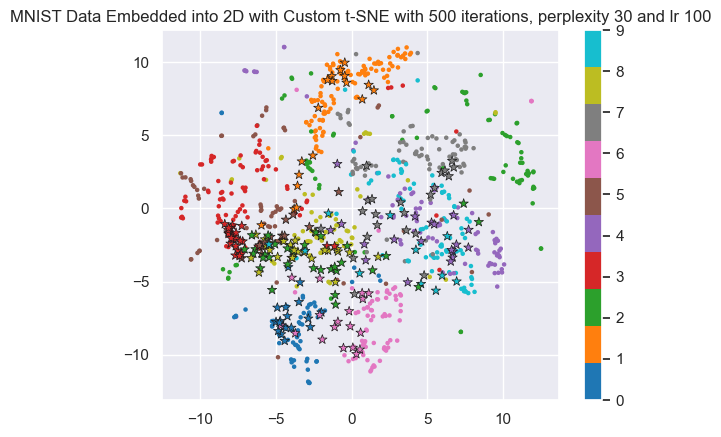

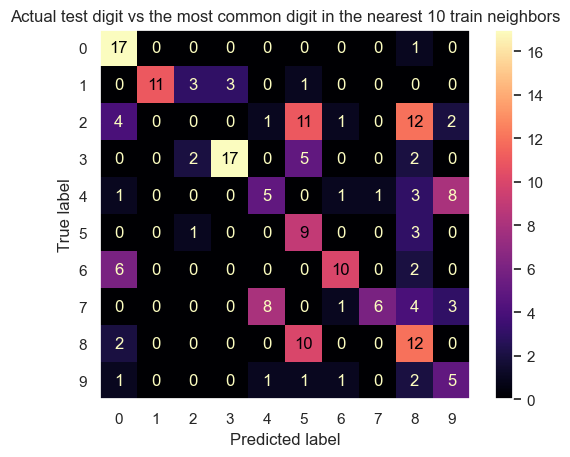

,precision,recall
0,0.506303,0.46


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,4,4,4,4,4,9,4,4,4,6
1,6,0,0,0,0,0,0,0,0,0,0
2,4,9,4,4,4,3,5,9,9,9,4
3,4,9,9,9,9,9,9,9,4,9,9
4,7,4,4,4,8,8,9,9,4,4,7
5,9,8,9,3,6,6,4,8,6,9,9
6,7,4,4,4,8,9,8,9,4,4,7
7,2,0,2,8,5,5,8,8,5,8,0
8,7,7,2,9,7,7,7,7,9,9,4
9,0,0,0,6,0,0,0,0,0,0,0


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.206506,0.233204,0.269212,0.600450,0.699074,0.867175,1.062578,1.093751,1.178778,1.293728
1,6,1.447836,1.528703,1.556000,1.556806,1.590386,1.639058,1.647343,1.674363,1.676220,1.677078
2,4,0.475223,0.477058,0.522067,0.580364,0.582347,0.700072,0.712321,0.839693,0.869622,0.913763
3,4,0.317069,0.506221,0.557669,0.643315,0.721015,0.731232,0.741611,0.931802,0.999211,1.026378
4,7,0.003070,0.080748,0.086858,0.572351,1.033911,1.172363,1.383800,1.434174,1.658889,1.709337
5,9,0.748036,1.125568,1.547005,1.548906,1.549261,1.628316,1.665136,1.728484,1.753980,1.761899
6,7,0.222618,0.282438,0.295533,0.789327,1.095700,1.175850,1.273654,1.371685,1.421546,1.669409
7,2,0.903947,1.136451,1.148278,1.214348,1.272397,1.330153,1.402385,1.423241,1.435061,1.492757
8,7,0.593500,0.662912,0.804587,0.848672,0.877985,0.913891,0.965675,1.092866,1.103699,1.127343
9,0,0.031410,0.109201,1.184011,1.199347,1.233281,1.249381,1.283211,1.304041,1.310754,1.325812


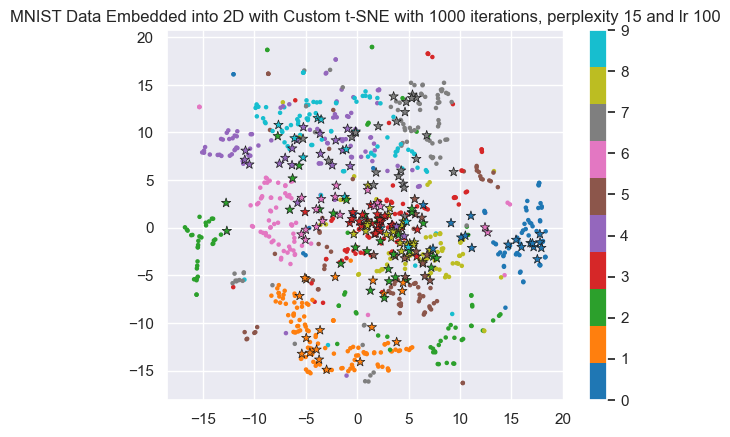

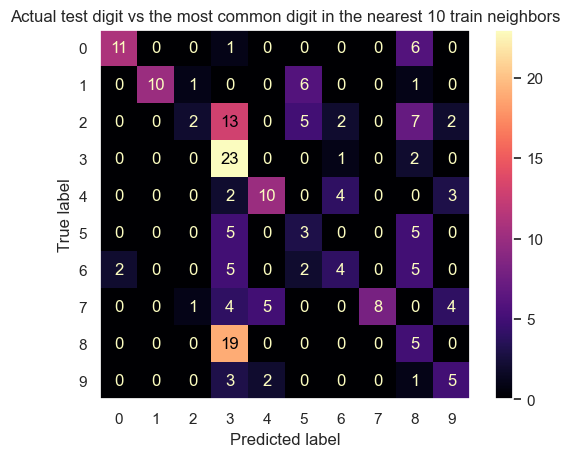

,precision,recall
0,0.53271,0.405


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,4,4,4,4,2,4,2,2,4,4
1,6,3,3,3,3,3,3,3,3,3,3
2,4,4,4,4,4,4,4,4,4,4,4
3,4,9,4,9,9,9,9,9,9,8,9
4,7,3,3,3,3,3,3,3,3,3,5
5,9,9,9,9,4,4,4,9,8,9,9
6,7,9,4,3,4,4,9,9,4,4,4
7,2,6,6,6,6,6,6,6,6,6,6
8,7,7,2,7,7,7,9,7,4,9,4
9,0,8,8,8,2,2,7,8,8,8,8


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.247277,0.468483,0.639937,1.259455,1.344713,1.493963,1.508328,1.545743,1.561043,1.585837
1,6,0.564764,0.614661,0.839149,1.039850,1.202865,1.237149,1.324717,1.407905,1.444105,1.605366
2,4,0.767969,0.830276,0.987829,1.112565,1.203670,1.252196,1.298596,1.323023,1.380100,1.603475
3,4,0.605300,0.695804,0.789849,0.859407,0.871388,0.967291,1.002637,1.017847,1.162688,1.229045
4,7,0.174268,0.239617,0.545012,0.606228,0.979229,1.325774,1.392962,1.427431,1.490107,1.564784
5,9,1.522263,1.574802,1.588029,1.650621,1.667243,1.850011,1.914145,2.113571,2.379282,2.408302
6,7,0.883488,1.085047,1.123870,1.214632,1.484328,2.049201,2.184056,2.196455,2.283929,2.300256
7,2,1.206842,1.350035,1.381088,1.450045,1.510968,1.519480,1.531895,1.560799,1.610496,1.682826
8,7,0.574993,0.889290,0.889486,1.090671,1.132227,1.472624,1.490569,1.565947,1.589249,1.592543
9,0,0.327232,0.511948,0.555132,0.736391,1.259617,1.361896,1.755762,1.937078,1.938894,2.070814


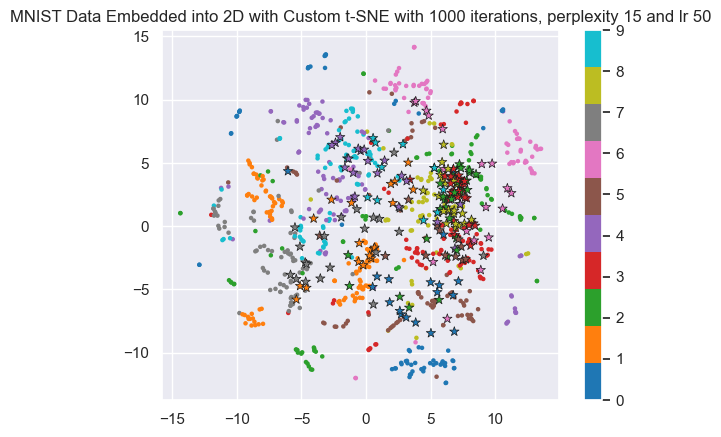

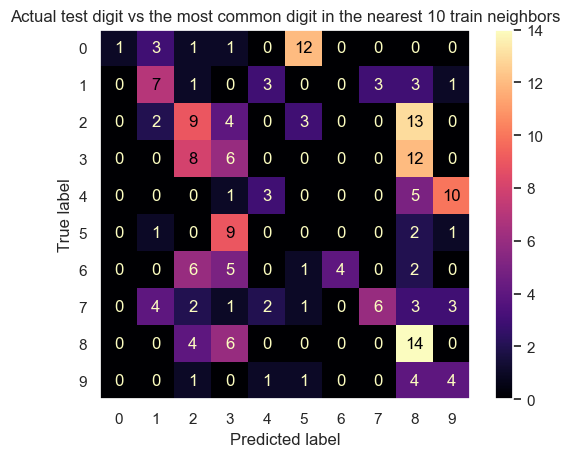

,precision,recall
0,0.429833,0.27


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,5,4,4,4,4,4,4,9,9,9
1,6,3,3,3,3,3,3,3,3,3,3
2,4,4,6,4,4,7,4,9,9,9,9
3,4,9,9,9,9,9,7,3,9,7,4
4,7,8,8,8,8,2,2,2,2,5,5
5,9,5,3,5,5,5,2,2,2,8,7
6,7,9,7,9,9,9,7,9,7,9,9
7,2,2,2,2,8,8,8,2,2,2,2
8,7,7,9,7,7,7,7,2,7,7,7
9,0,5,5,5,5,5,5,3,3,5,5


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.215948,0.640069,0.664931,1.081095,1.097286,1.110735,1.239778,1.240048,1.299882,1.341257
1,6,0.199874,0.529475,0.620529,0.643712,0.734072,0.847504,1.169995,1.230580,1.306619,1.347086
2,4,0.221243,0.364454,0.470166,0.487798,0.488334,0.891959,0.930102,0.938158,0.969054,1.011536
3,4,0.586921,0.665959,0.713377,0.835528,1.136690,1.287257,1.337616,1.360518,1.382382,1.479889
4,7,0.491778,0.547249,0.618227,0.692605,1.039200,1.076287,1.089485,1.316291,1.749160,2.037657
5,9,0.300525,0.563547,0.572328,0.831792,1.297528,1.486128,1.513031,1.522558,1.548684,1.568379
6,7,0.345057,0.471463,0.472263,0.472507,0.476995,0.552602,0.701109,0.825849,0.836105,0.920781
7,2,0.536530,0.697324,0.775246,0.976895,0.997810,0.998506,1.127950,1.222458,1.304711,1.478281
8,7,0.082366,0.412227,0.424299,0.520330,0.543564,0.792588,0.872586,0.902464,0.926894,1.035872
9,0,0.996641,1.048780,1.057833,1.112947,1.124850,1.223256,1.246329,1.325817,1.353522,1.370647


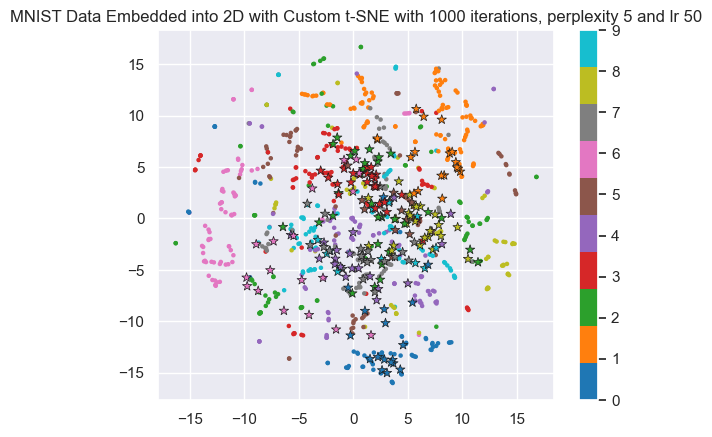

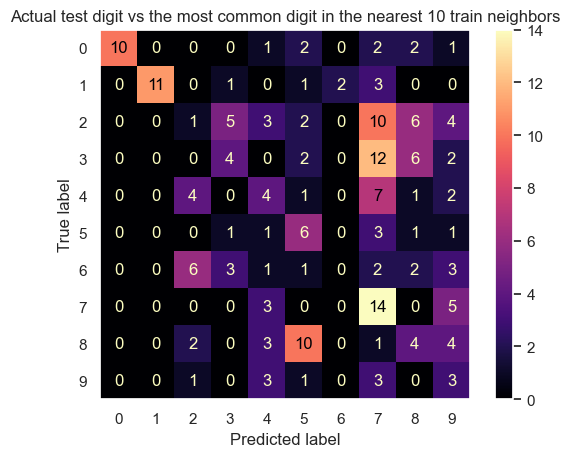

,precision,recall
0,0.31865,0.285


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,9,9,9,4,9,9,4,8,9,9
1,6,2,2,2,2,2,2,2,4,4,4
2,4,8,4,9,4,9,9,9,9,4,9
3,4,4,9,9,4,4,7,9,4,9,8
4,7,9,9,9,4,4,9,4,0,5,9
5,9,7,7,7,7,7,7,7,2,2,7
6,7,2,7,7,7,2,7,7,7,7,7
7,2,8,8,8,8,8,8,8,3,9,7
8,7,2,2,2,2,7,7,7,7,7,9
9,0,8,8,8,9,8,8,8,5,5,5


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.378186,0.608944,0.770501,0.891654,0.930326,0.995331,1.034944,1.122133,1.122234,1.125170
1,6,0.983433,1.003798,1.006818,1.008011,1.047063,1.573145,1.593550,1.752126,1.790006,1.840557
2,4,0.810072,0.886926,0.908751,0.931523,1.049883,1.109957,1.119032,1.168345,1.198698,1.323913
3,4,0.851153,0.893645,0.956361,0.959644,1.050161,1.083623,1.084147,1.100119,1.149409,1.166409
4,7,0.641300,0.857652,1.107827,1.408124,1.519438,1.575257,1.638512,1.647047,1.728290,1.820545
5,9,0.574971,0.826314,0.930648,1.056003,1.062959,1.208596,1.433064,1.446728,1.522177,1.558708
6,7,0.511790,0.607270,1.123645,1.197451,1.340544,1.444120,1.488937,1.506757,1.584295,1.602602
7,2,0.344350,0.749617,0.824886,0.956912,1.325700,1.468437,1.635565,1.725926,1.756191,1.760459
8,7,0.208610,0.323447,0.331871,0.387869,1.100302,1.290860,1.309769,1.687492,1.720678,1.728155
9,0,0.747524,0.853631,0.941798,1.006693,1.161426,1.189875,1.190851,1.594120,1.730584,2.025309


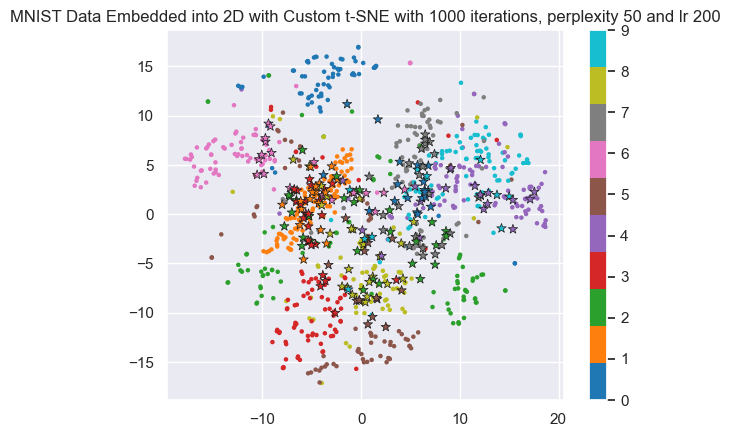

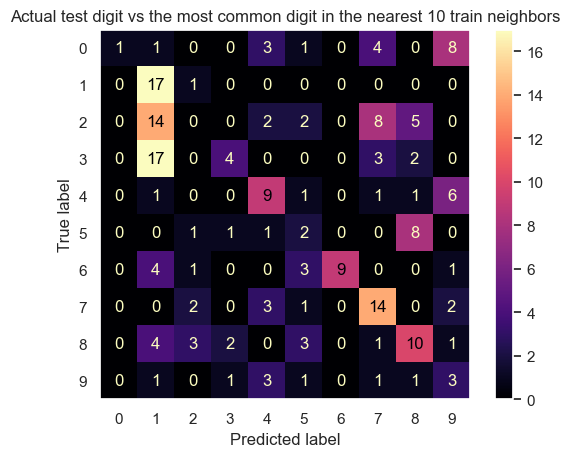

,precision,recall
0,0.421359,0.345


10 Closests train actual digits for each test digit


,actual digit,1 closest digit,2 closest digit,3 closest digit,4 closest digit,5 closest digit,6 closest digit,7 closest digit,8 closest digit,9 closest digit,10 closest digit
0,9,7,7,7,7,7,7,7,9,7,9
1,6,5,5,5,5,5,4,5,4,4,6
2,4,5,4,4,4,4,4,4,4,9,4
3,4,9,9,9,9,9,4,9,4,4,4
4,7,4,9,8,4,4,4,5,4,8,5
5,9,4,9,4,9,9,4,4,9,9,9
6,7,3,7,7,7,7,7,7,7,7,9
7,2,5,3,5,5,5,5,5,3,3,6
8,7,7,7,2,7,7,9,9,7,7,9
9,0,9,9,9,9,4,9,9,9,7,7


10 Closests train distances for each test oservability


,actual digit,1 closest distance,2 closest distance,3 closest distance,4 closest distance,5 closest distance,6 closest distance,7 closest distance,8 closest distance,9 closest distance,10 closest distance
0,9,0.693193,0.888100,0.972590,0.979698,1.056781,1.153808,1.154617,1.255426,1.264936,1.337247
1,6,0.579227,0.764036,0.822172,1.092936,1.162722,1.531882,1.732637,1.762013,1.767574,1.956662
2,4,0.387726,0.808617,0.995780,1.004792,1.017219,1.039462,1.125912,1.403142,1.405361,1.456625
3,4,0.363041,0.417490,0.957489,1.094547,1.108135,1.326510,1.356585,1.534516,1.673847,1.708710
4,7,1.026208,1.074247,1.085824,1.439220,1.546034,1.573568,1.574727,1.575578,1.707395,1.726559
5,9,0.475599,0.587126,0.639445,0.843655,1.003505,1.147752,1.201280,1.218800,1.258305,1.259524
6,7,0.253637,0.291217,0.451366,0.641571,0.748287,0.819447,0.922117,1.089637,1.093107,1.502149
7,2,0.444124,0.673578,0.684737,1.120333,1.420106,1.645108,2.050705,2.167029,2.189911,2.481859
8,7,0.736764,0.758033,1.010490,1.044462,1.087500,1.357870,1.367254,1.447493,1.499052,1.559778
9,0,0.322318,0.348800,0.604711,0.900578,1.035288,1.053778,1.371160,1.378602,1.395015,1.618514


In [ ]:
for idx, result in enumerate(results_array):
    # Transform new data
    custom_Y_new = custom_tsne.transform(
        X_train_normalized_opt1, result["custom_Y"], X_test
    )

    # Visualization of the result
    plt.figure()
    plt.scatter(
        result["custom_Y"][:, 0],
        result["custom_Y"][:, 1],
        s=5,
        c=label_train.astype(int),
        cmap="tab10",
    )
    plt.scatter(
        custom_Y_new[:, 0],
        custom_Y_new[:, 1],
        marker="*",
        s=50,
        linewidths=0.5,
        edgecolors="k",
        c=label_test.astype(int),
        cmap="tab10",
    )
    plt.colorbar()
    plt.title(
        f"MNIST Data Embedded into 2D with Custom t-SNE with {hypher_pharams_options[idx]['n_iter']} iterations, perplexity {hypher_pharams_options[idx]['perplexity']} and lr {hypher_pharams_options[idx]['learning_rate']}"
    )
    plt.show()

    # Top 10 nearest neighbor of each test set
    dists = cdist(custom_Y_new, result["custom_Y"])
    n_nearest_digits = label_train[np.argsort(dists, axis=1)[:, :10]]
    n_nearest_distances = np.sort(dists, axis=1)[:, :10]

    df1 = pd.DataFrame(label_test, columns=["actual digit"])
    df2 = pd.DataFrame(
        n_nearest_digits,
        columns=[f"{idx+1} closest digit" for idx in range(n_nearest_digits.shape[1])],
    )
    df3 = pd.DataFrame(
        n_nearest_distances,
        columns=[
            f"{idx+1} closest distance" for idx in range(n_nearest_distances.shape[1])
        ],
    )
    df_digits = df1.join(df2)
    df_distances = df1.join(df3)

    most_common_neigbors_digits = np.array(
        [np.bincount(row).argmax() for row in n_nearest_digits]
    )
    digits_matrix = confusion_matrix(label_test, most_common_neigbors_digits)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=digits_matrix)
    cm_display.plot(cmap="magma")
    plt.title(
        "Actual test digit vs the most common digit in the nearest 10 train neighbors"
    )
    plt.grid(False)
    plt.show()

    df_measures = pd.DataFrame(
        [
            [
                precision_score(
                    label_test, most_common_neigbors_digits, average="weighted"
                ),
                recall_score(
                    label_test, most_common_neigbors_digits, average="weighted"
                ),
            ]
        ],
        columns=["precision", "recall"],
    )
    display(df_measures)

    print("10 Closests train actual digits for each test digit")
    display(df_digits[:20])
    print("10 Closests train distances for each test oservability")
    display(df_distances[:20])

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment. 

We used ChatGPT to help us utilize numpy vectorised functions more effieintly. It also proposed subtracting the maximum when calculating exponents, in order to avoid very large/small values.